# Alzheimer's prediction

## What is Alzheimer's disease (AD)?

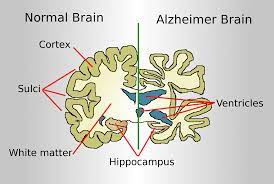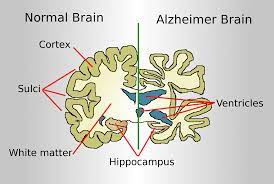

Alzheimer's disease (AD) is a neurodegenerative disease that usually starts slowly and progressively worsens.It is the cause of 60–70% of cases of dementia.The most common early symptom is difficulty in remembering recent events. As the disease advances, symptoms can include problems with language, disorientation (including easily getting lost), mood swings, loss of motivation, self-neglect, and behavioral issues. As a person's condition declines, they often withdraw from family and society.Gradually, bodily functions are lost, ultimately leading to death. Although the speed of progression can vary, the typical life expectancy following diagnosis is three to nine years.

## What is Dementia?

Dementia is a general term for loss of memory, language, problem-solving and other thinking abilities that are severe enough to interfere with daily life. Alzheimer's is the most common cause of dementia, a general term for memory loss and other cognitive abilities serious enough to interfere with daily life. Alzheimer's disease accounts for 60-80% of dementia cases.

### Our problem statement

Estimating the CDR (scale of Dementia) using relevant features in the MRI dataset.

The CDR is based on a scale of 0–3: no dementia (CDR = 0), questionable dementia (CDR = 0.5), MCI (CDR = 1), moderate cognitive impairment (CDR = 2), and severe cognitive impairment (CDR = 3).

In [ ]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

## Reading the Cross-sectional and Longitudinal MRI datasets.

We describe the attributes in the dataset with data_cross.info() and data_long.info()

In [ ]:
data_cross = pd.read_csv("../input/mri-and-alzheimers/oasis_cross-sectional.csv")
data_long = pd.read_csv("../input/mri-and-alzheimers/oasis_longitudinal.csv")
print(data_cross.info())
print(data_long.info())

## Checking for null values.

In [ ]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

Since we will be predicting on the variable "CDR", we drop all the rows with undefined or null values

In [ ]:
data_cross.dropna(subset=['CDR'],inplace=True)

## Removing unnecessary columns in both datasets.
The unique columns would be of no use in estimating the dependent variable "CDR"

In [ ]:
data_cross.drop(columns=['ID','Delay'],inplace=True)
data_long = data_long.rename(columns={'EDUC':'Educ'})
data_long.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)

## Appending both the datasets.

In [ ]:
data = pd.concat([data_cross,data_long])
data.head()

In [ ]:
data.describe()

In [ ]:
cor = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, xticklabels=cor.columns.values,yticklabels=cor.columns.values, annot=True)


## Using Pandas_Profiling to analyze the correlation between variables.

In [ ]:
import pandas_profiling as pp
pp.ProfileReport(data)

In [ ]:
data.isna().sum()

## Imputing columns using SimpleImputer.
We fill in the missing values in the "SES" columns with the most occuring data element.
Similarly, we fill the missing values in the "MMSE" column with the median of that column.

In [ ]:
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])

In [ ]:
data

## Encoding the Target variable using LabelEncoder.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['CDR'] = le.fit_transform(data['CDR'].values)

Converting categorical variables to numeric using OneHot encoding.

In [ ]:
data = pd.get_dummies(data)

## Plotting the distribution of classes on a barplot.

In [ ]:
plt.bar(data['CDR'].unique(),data['CDR'].value_counts())

Neglecting the last class due to negligible size in the combined dataset.

In [ ]:
data = data.drop(data[data['CDR']==3].index)
data.info()

In [ ]:
y = data.pop('CDR')
x = data

## Normalizing the data.
We observe that different columns have different ranges of values. We use Z-score normalization in this case.

In [ ]:
x = StandardScaler().fit_transform(x)

## Dividing dataset into train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42,test_size=0.3)

## Defining Models.

### 1. We will try hyperparameter tuning using cross-validation for XGBClassifier.

In [ ]:
from xgboost import XGBClassifier
FOLDS = 5

parametros_xgb = {
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "n_estimators":range(1,1000)
    }

model_xgb= XGBClassifier(eval_metric='mlogloss')


xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = parametros_xgb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
xgb_random.fit(X_train, y_train)

xgb_random.best_params_

In [ ]:
model_xgb = xgb_random.best_estimator_
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)

### 2. Trying hyperparameter tuning of GradientBoostingClassifier.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
FOLDS =10

parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,100)
    }

model_gb= GradientBoostingClassifier()


gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
gb_random.fit(X_train, y_train)

gb_random.best_params_

In [ ]:
model_gb = gb_random.best_estimator_
print(model_gb.score(X_test,y_test))

GradientBoosting model performs better than XGboost, Hence we try 10-fold cross validation on GradientBoostingClassifier model to improve accuracy.

In [ ]:
cross_val_score(model_gb, x, y, cv=10, scoring='accuracy').mean()

### Making predictions using the best estimator and plotting the confusion matrix along with classification report.

In [ ]:
y_pred = model_gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


## Please upvote if you found it useful :)